Feature dtypes:
 Pregnancies                 float64
Glucose                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                         float64
Glucose_Insulin             float64
dtype: object
Class Distribution after SMOTE:
 Outcome
1    500
0    500
Name: count, dtype: int64
Shapes: (768, 6) (800, 6) (200, 6)


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Accuracy: 0.8825
Test Accuracy: 0.82
Test F1-Score: 0.8163265306122449
Test AUC-ROC: 0.876
Confusion Matrix:
 [[84 16]
 [20 80]]
Cross-Validation Accuracy: 0.789 ± 0.05589275444992851
Prediction for input data: Diabetic


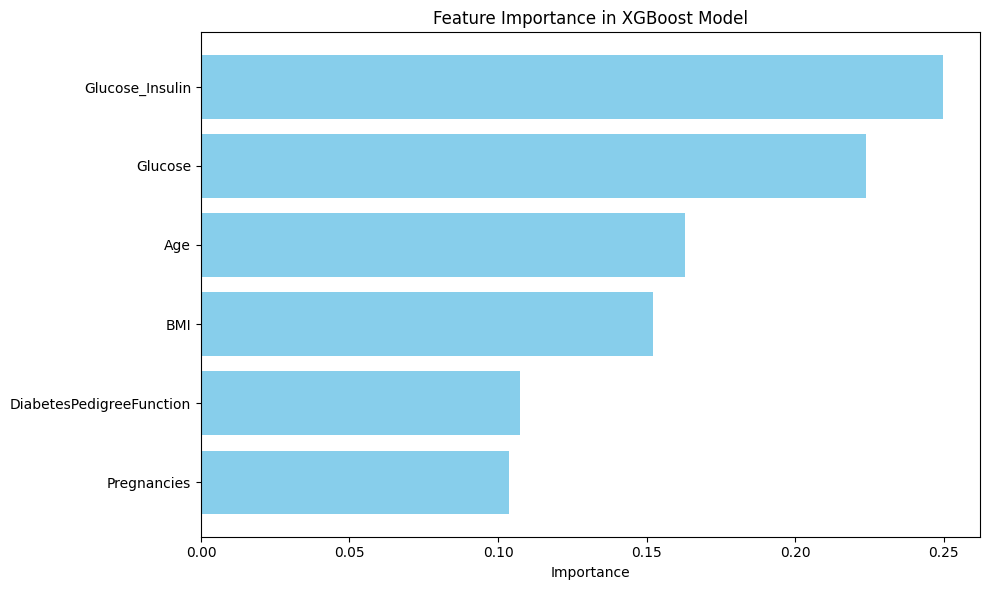

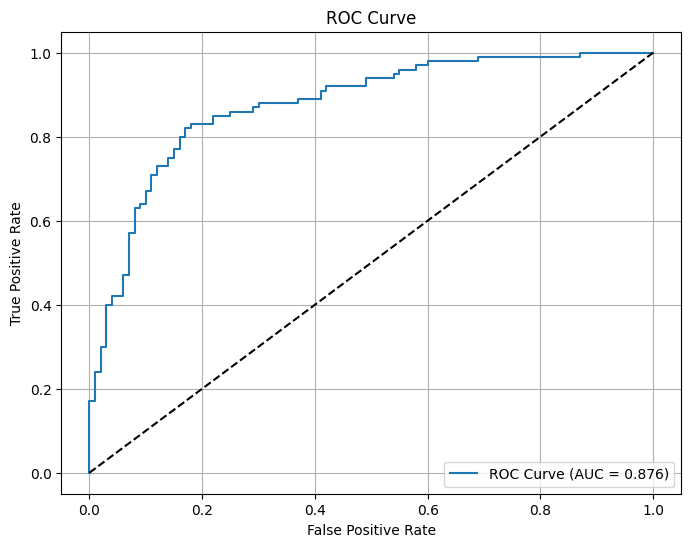

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Load dataset
diabetes_dataset = pd.read_csv('diabetes.csv')

# Step 1: Define columns for imputation
cols_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Step 2: Handle zero values (missing data)
diabetes_dataset[cols_to_impute] = diabetes_dataset[cols_to_impute].replace(0, np.nan)
imputer = KNNImputer(n_neighbors=5)
diabetes_dataset[cols_to_impute] = imputer.fit_transform(diabetes_dataset[cols_to_impute])

# Step 3: Handle outliers (cap at 95th percentile)
diabetes_dataset['Insulin'] = diabetes_dataset['Insulin'].clip(upper=diabetes_dataset['Insulin'].quantile(0.95))
diabetes_dataset['DiabetesPedigreeFunction'] = diabetes_dataset['DiabetesPedigreeFunction'].clip(upper=diabetes_dataset['DiabetesPedigreeFunction'].quantile(0.95))

# Step 4: Feature engineering
# Add Glucose-Insulin interaction
diabetes_dataset['Glucose_Insulin'] = diabetes_dataset['Glucose'] * diabetes_dataset['Insulin']

# Step 5: Drop low-importance features
X = diabetes_dataset.drop(columns=['Outcome', 'SkinThickness', 'Insulin', 'BloodPressure'], axis=1)
Y = diabetes_dataset['Outcome']

# Step 6: Ensure all features are numeric
X = X.astype(float)
print("Feature dtypes:\n", X.dtypes)

# Step 7: Address class imbalance with SMOTE
smote = SMOTE(random_state=2)
X_balanced, Y_balanced = smote.fit_resample(X, Y)
print("Class Distribution after SMOTE:\n", pd.Series(Y_balanced).value_counts())

# Step 8: Feature scaling
scaler = StandardScaler()
X_balanced = scaler.fit_transform(X_balanced)

# Step 9: Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_balanced, Y_balanced, test_size=0.2, stratify=Y_balanced, random_state=2)
print("Shapes:", X.shape, X_train.shape, X_test.shape)

# Step 10: Train XGBoost with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 3]
}
xgb = XGBClassifier(random_state=2, eval_metric='logloss')
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, Y_train)
classifier = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Step 11: Evaluate model
# Training accuracy
X_train_prediction = classifier.predict(X_train)
training_accuracy = accuracy_score(X_train_prediction, Y_train)
print("Training Accuracy:", training_accuracy)

# Test accuracy
X_test_prediction = classifier.predict(X_test)
test_accuracy = accuracy_score(X_test_prediction, Y_test)
print("Test Accuracy:", test_accuracy)

# Additional metrics
print("Test F1-Score:", f1_score(Y_test, X_test_prediction))
print("Test AUC-ROC:", roc_auc_score(Y_test, classifier.predict_proba(X_test)[:, 1]))
print("Confusion Matrix:\n", confusion_matrix(Y_test, X_test_prediction))

# Step 12: Cross-validation
cv_scores = cross_val_score(classifier, X_balanced, Y_balanced, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy: {} ± {}".format(cv_scores.mean(), cv_scores.std()))

# Step 13: Predict on new data
input_data = (5, 166, 72, 19, 175, 25.8, 0.587, 51)  # Example input
input_df = pd.DataFrame([input_data], columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
input_df[cols_to_impute] = input_df[cols_to_impute].replace(0, np.nan)
input_df[cols_to_impute] = imputer.transform(input_df[cols_to_impute])
input_df['Insulin'] = input_df['Insulin'].clip(upper=diabetes_dataset['Insulin'].quantile(0.95))
input_df['DiabetesPedigreeFunction'] = input_df['DiabetesPedigreeFunction'].clip(upper=diabetes_dataset['DiabetesPedigreeFunction'].quantile(0.95))
input_df['Glucose_Insulin'] = input_df['Glucose'] * input_df['Insulin']
input_df = input_df[X.columns].astype(float)  # Ensure same features and numeric dtypes
std_data = scaler.transform(input_df)
prediction = classifier.predict(std_data)
print("Prediction for input data:", "Diabetic" if prediction[0] == 1 else "Not Diabetic")

# Step 14: Save the cleaned dataset (optional)
diabetes_dataset.to_csv('diabetes_cleaned.csv', index=False)

# Step 15: Plot feature importance
importance_data = pd.DataFrame({
    'Feature': X.columns,
    'Importance': classifier.feature_importances_
}).sort_values(by='Importance', ascending=True)
plt.figure(figsize=(10, 6))
plt.barh(importance_data['Feature'], importance_data['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in XGBoost Model')
plt.tight_layout()
plt.show()

# Step 16: Plot ROC curve
y_pred_proba = classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(Y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(Y_test, y_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Feature dtypes:
 Pregnancies                 float64
Glucose                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                         float64
Glucose_Insulin             float64
dtype: object
Class Distribution after SMOTE:
 Outcome
1    500
0    500
Name: count, dtype: int64
Shapes: (768, 6) (800, 6) (200, 6)


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Training Accuracy: 0.8825
Test Accuracy: 0.82
Test F1-Score: 0.8163265306122449
Test AUC-ROC: 0.876
Confusion Matrix:
 [[84 16]
 [20 80]]
Cross-Validation Accuracy: 0.789 ± 0.05589275444992851
Prediction for input data: Diabetic


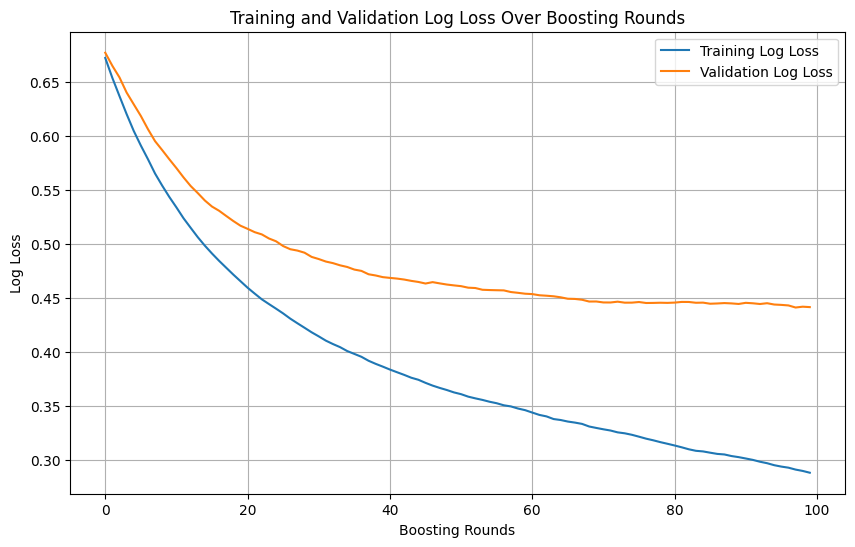

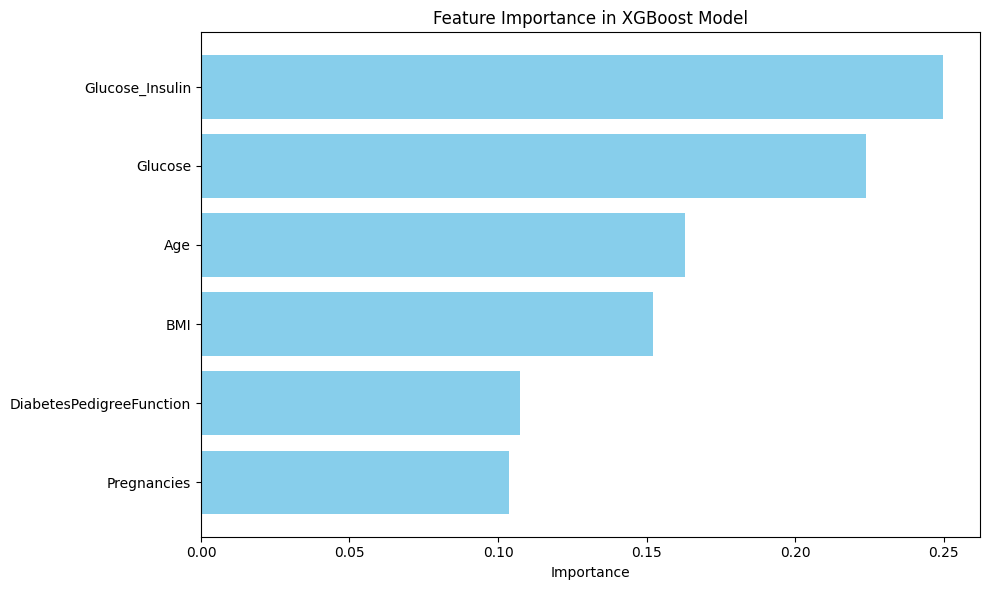

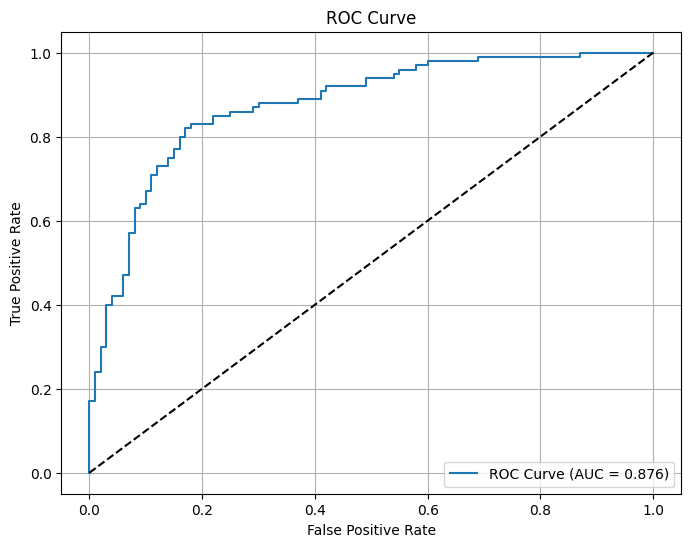

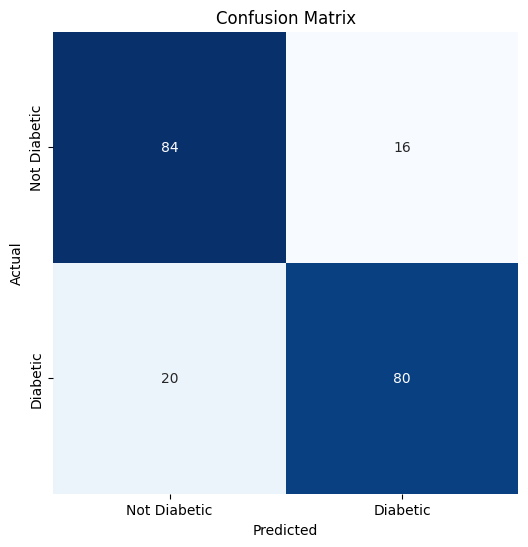

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Load dataset
diabetes_dataset = pd.read_csv('diabetes.csv')

# Step 1: Define columns for imputation
cols_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Step 2: Handle zero values (missing data)
diabetes_dataset[cols_to_impute] = diabetes_dataset[cols_to_impute].replace(0, np.nan)
imputer = KNNImputer(n_neighbors=5)
diabetes_dataset[cols_to_impute] = imputer.fit_transform(diabetes_dataset[cols_to_impute])

# Step 3: Handle outliers (cap at 95th percentile)
diabetes_dataset['Insulin'] = diabetes_dataset['Insulin'].clip(upper=diabetes_dataset['Insulin'].quantile(0.95))
diabetes_dataset['DiabetesPedigreeFunction'] = diabetes_dataset['DiabetesPedigreeFunction'].clip(upper=diabetes_dataset['DiabetesPedigreeFunction'].quantile(0.95))

# Step 4: Feature engineering
# Add Glucose-Insulin interaction
diabetes_dataset['Glucose_Insulin'] = diabetes_dataset['Glucose'] * diabetes_dataset['Insulin']

# Step 5: Drop low-importance features
X = diabetes_dataset.drop(columns=['Outcome', 'SkinThickness', 'Insulin', 'BloodPressure'], axis=1)
Y = diabetes_dataset['Outcome']

# Step 6: Ensure all features are numeric
X = X.astype(float)
print("Feature dtypes:\n", X.dtypes)

# Step 7: Address class imbalance with SMOTE
smote = SMOTE(random_state=2)
X_balanced, Y_balanced = smote.fit_resample(X, Y)
print("Class Distribution after SMOTE:\n", pd.Series(Y_balanced).value_counts())

# Step 8: Feature scaling
scaler = StandardScaler()
X_balanced = scaler.fit_transform(X_balanced)

# Step 9: Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_balanced, Y_balanced, test_size=0.2, stratify=Y_balanced, random_state=2)
print("Shapes:", X.shape, X_train.shape, X_test.shape)

# Step 10: Train XGBoost with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.03, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 3]
}
xgb = XGBClassifier(random_state=2, eval_metric='logloss')
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, Y_train)
classifier = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Step 11: Train with evaluation metrics to plot training graph
eval_set = [(X_train, Y_train), (X_test, Y_test)]
classifier.fit(X_train, Y_train, eval_set=eval_set, verbose=False)
evals_result = classifier.evals_result()

# Step 12: Evaluate model
# Training accuracy
X_train_prediction = classifier.predict(X_train)
training_accuracy = accuracy_score(X_train_prediction, Y_train)
print("Training Accuracy:", training_accuracy)

# Test accuracy
X_test_prediction = classifier.predict(X_test)
test_accuracy = accuracy_score(X_test_prediction, Y_test)
print("Test Accuracy:", test_accuracy)

# Additional metrics
print("Test F1-Score:", f1_score(Y_test, X_test_prediction))
print("Test AUC-ROC:", roc_auc_score(Y_test, classifier.predict_proba(X_test)[:, 1]))
print("Confusion Matrix:\n", confusion_matrix(Y_test, X_test_prediction))

# Step 13: Cross-validation
cv_scores = cross_val_score(classifier, X_balanced, Y_balanced, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy: {} ± {}".format(cv_scores.mean(), cv_scores.std()))

# Step 14: Predict on new data
input_data = (5, 166, 72, 19, 175, 25.8, 0.587, 51)  # Example input
input_df = pd.DataFrame([input_data], columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
input_df[cols_to_impute] = input_df[cols_to_impute].replace(0, np.nan)
input_df[cols_to_impute] = imputer.transform(input_df[cols_to_impute])
input_df['Insulin'] = input_df['Insulin'].clip(upper=diabetes_dataset['Insulin'].quantile(0.95))
input_df['DiabetesPedigreeFunction'] = input_df['DiabetesPedigreeFunction'].clip(upper=diabetes_dataset['DiabetesPedigreeFunction'].quantile(0.95))
input_df['Glucose_Insulin'] = input_df['Glucose'] * input_df['Insulin']
input_df = input_df[X.columns].astype(float)  # Ensure same features and numeric dtypes
std_data = scaler.transform(input_df)
prediction = classifier.predict(std_data)
print("Prediction for input data:", "Diabetic" if prediction[0] == 1 else "Not Diabetic")

# Step 15: Save the cleaned dataset (optional)
diabetes_dataset.to_csv('diabetes_cleaned.csv', index=False)

# Step 16: Plot training and validation log loss
plt.figure(figsize=(10, 6))
train_logloss = evals_result['validation_0']['logloss']
test_logloss = evals_result['validation_1']['logloss']
plt.plot(train_logloss, label='Training Log Loss')
plt.plot(test_logloss, label='Validation Log Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('Training and Validation Log Loss Over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()

# Step 17: Plot feature importance
importance_data = pd.DataFrame({
    'Feature': X.columns,
    'Importance': classifier.feature_importances_
}).sort_values(by='Importance', ascending=True)
plt.figure(figsize=(10, 6))
plt.barh(importance_data['Feature'], importance_data['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in XGBoost Model')
plt.tight_layout()
plt.show()

# Step 18: Plot ROC curve
y_pred_proba = classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(Y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(Y_test, y_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Step 19: Plot confusion matrix
cm = confusion_matrix(Y_test, X_test_prediction)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Diabetic', 'Diabetic'],
            yticklabels=['Not Diabetic', 'Diabetic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [3]:
import pickle

# Save the trained model, scaler, imputer, and feature columns
model_data = {
    'model': classifier,
    'scaler': scaler,
    'imputer': imputer,
    'columns': list(X.columns)
}

with open('diabetes_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Model saved as diabetes_model.pkl")


Model saved as diabetes_model.pkl


In [1]:
import tkinter as tk
from tkinter import messagebox
import numpy as np
import pandas as pd
import pickle

# Load saved model and preprocessing tools
with open('diabetes_model.pkl', 'rb') as f:
    model_data = pickle.load(f)

model = model_data['model']
scaler = model_data['scaler']
imputer = model_data['imputer']
columns = model_data['columns']

def predict_diabetes():
    try:
        # Get input values from entries
        values = [
            float(entry_pregnancies.get()),
            float(entry_glucose.get()),
            float(entry_bp.get()),
            float(entry_skin.get()),
            float(entry_insulin.get()),
            float(entry_bmi.get()),
            float(entry_dpf.get()),
            float(entry_age.get())
        ]

        # Create DataFrame
        input_df = pd.DataFrame([values], columns=[
            'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'
        ])

        # Impute missing
        input_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = \
            input_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)
        input_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = \
            imputer.transform(input_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']])

        # Feature engineering
        input_df['Glucose_Insulin'] = input_df['Glucose'] * input_df['Insulin']
        input_df = input_df.drop(columns=['SkinThickness', 'Insulin', 'BloodPressure'])  # match model features

        # Align columns
        input_df = input_df[columns]

        # Scale input
        std_data = scaler.transform(input_df)

        # Predict
        prediction = model.predict(std_data)
        result = "Diabetic" if prediction[0] == 1 else "Not Diabetic"
        messagebox.showinfo("Prediction", f"The person is likely: {result}")

    except Exception as e:
        messagebox.showerror("Error", str(e))

# Tkinter GUI
root = tk.Tk()
root.title("Diabetes Predictor")
root.geometry("400x450")

# Input labels and entries
labels = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
entries = []

for i, label in enumerate(labels):
    tk.Label(root, text=label).grid(row=i, column=0, padx=10, pady=5, sticky='e')
    entry = tk.Entry(root)
    entry.grid(row=i, column=1, padx=10, pady=5)
    entries.append(entry)

entry_pregnancies, entry_glucose, entry_bp, entry_skin, entry_insulin, entry_bmi, entry_dpf, entry_age = entries

# Predict button
tk.Button(root, text="Predict", command=predict_diabetes, bg='green', fg='white').grid(row=9, column=0, columnspan=2, pady=20)

root.mainloop()


In [2]:
import tkinter as tk
from tkinter import messagebox, ttk
import numpy as np
import pandas as pd
import pickle
import os

# Load saved model and preprocessing tools
with open('diabetes_model.pkl', 'rb') as f:
    model_data = pickle.load(f)

model = model_data['model']
scaler = model_data['scaler']
imputer = model_data['imputer']
columns = model_data['columns']

# Initialize or load prediction history
history_file = 'prediction_history.csv'
if os.path.exists(history_file) and os.path.getsize(history_file) > 0:
    history_df = pd.read_csv(history_file)
else:
    history_df = pd.DataFrame(columns=[
        'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
        'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Prediction'
    ])
    history_df.to_csv(history_file, index=False)

def predict_diabetes():
    try:
        # Get input values from entries
        values = [
            float(entry_pregnancies.get()),
            float(entry_glucose.get()),
            float(entry_bp.get()),
            float(entry_skin.get()),
            float(entry_insulin.get()),
            float(entry_bmi.get()),
            float(entry_dpf.get()),
            float(entry_age.get())
        ]

        # Create DataFrame
        input_df = pd.DataFrame([values], columns=[
            'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'
        ])

        # Impute missing
        input_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = \
            input_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)
        input_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = \
            imputer.transform(input_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']])

        # Feature engineering
        input_df['Glucose_Insulin'] = input_df['Glucose'] * input_df['Insulin']
        model_input_df = input_df.drop(columns=['SkinThickness', 'Insulin', 'BloodPressure'])  # match model features

        # Align columns
        model_input_df = model_input_df[columns]

        # Scale input
        std_data = scaler.transform(model_input_df)

        # Predict
        prediction = model.predict(std_data)
        result = "Diabetic" if prediction[0] == 1 else "Not Diabetic"
        messagebox.showinfo("Prediction", f"The person is likely: {result}")
        
        # Save prediction to history
        new_row = input_df.iloc[0].to_dict()
        new_row['Prediction'] = result
        global history_df
        history_df = pd.concat([history_df, pd.DataFrame([new_row])], ignore_index=True)
        history_df.to_csv(history_file, index=False)
        
        # Update the history table
        update_history_table()

    except Exception as e:
        messagebox.showerror("Error", str(e))

def update_history_table():
    # Clear existing data
    for item in history_tree.get_children():
        history_tree.delete(item)
    
    # Add data to treeview
    for i, row in history_df.iterrows():
        values = [row['Pregnancies'], row['Glucose'], row['BloodPressure'], 
                 row['SkinThickness'], row['Insulin'], row['BMI'], 
                 row['DiabetesPedigreeFunction'], row['Age'], row['Prediction']]
        history_tree.insert("", "end", values=values)

# Tkinter GUI
root = tk.Tk()
root.title("Diabetes Predictor")
root.geometry("900x600")

# Create notebook (tabs)
nb = ttk.Notebook(root)
nb.pack(fill='both', expand=True, padx=10, pady=10)

# Input Frame
input_frame = ttk.Frame(nb)
nb.add(input_frame, text="Prediction Input")

# History Frame
history_frame = ttk.Frame(nb)
nb.add(history_frame, text="Prediction History")

# Input labels and entries
labels = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
entries = []

for i, label in enumerate(labels):
    tk.Label(input_frame, text=label).grid(row=i, column=0, padx=10, pady=5, sticky='e')
    entry = tk.Entry(input_frame)
    entry.grid(row=i, column=1, padx=10, pady=5)
    entries.append(entry)

entry_pregnancies, entry_glucose, entry_bp, entry_skin, entry_insulin, entry_bmi, entry_dpf, entry_age = entries

# Predict button
tk.Button(input_frame, text="Predict", command=predict_diabetes, bg='green', fg='white').grid(row=9, column=0, columnspan=2, pady=20)

# History table
history_tree = ttk.Treeview(history_frame)
history_tree["columns"] = ("Pregnancies", "Glucose", "BloodPressure", "SkinThickness", 
                         "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Prediction")

# Configure columns
history_tree.column("#0", width=0, stretch=tk.NO)
for col in history_tree["columns"]:
    history_tree.column(col, anchor=tk.CENTER, width=90)
    history_tree.heading(col, text=col)

# Add scrollbar
scrollbar = ttk.Scrollbar(history_frame, orient="vertical", command=history_tree.yview)
history_tree.configure(yscrollcommand=scrollbar.set)

# Pack history components
history_tree.pack(side="left", fill="both", expand=True, padx=10, pady=10)
scrollbar.pack(side="right", fill="y", pady=10)

# Initialize history table
update_history_table()

root.mainloop()
